# Visualize SuperLearner results

Below are some examples for how to load and plot results from the SuperLearner.

The key inputs to this notebook are specified in the
1. `model_dir` variable in **Load SuperLearner models**
2. `num_inputs`, `data_df`, and `target_name` in **Use the SuperLearner models** and
3. `permute_str` and `job_list` in **Feature permutation importance**

## Dependencies
**Note 1 - Notebooks versus code:** The instructions below are for running a SuperLearner model in a Jupyter notebook.  The SuperLearner model does not need to run in a Jupyter notebook - pure Python code works fine - but a notebook is used here to allow for more natural interactive use of the model.

**Note 2 - Portability and environment:** The code below is complicated by the fact that the current version of the SuperLearner archives its models as `.pkl` files.  While this format is fast and convenient, there are significant issues with portability and security.  As such, current work is focused on porting SuperLearner models to ONNX format - a single import statement can load the ONNX runtime and it is much less sensitive to the exact version of `scikit-learn`, `xgboost`, and Python that is running in your compute environment.

Before you can run this notebook with the model supplied here, you need to install the packages listed in `requirements.txt` into your Python environment (in additon to the packages available by default in the `base` Conda environment in `jupyter/scipy-notebook` Docker container; I am using a [slighty customized version of this container](https://hub.docker.com/r/stefanfgary/socks).). If you are not in a Docker container, using Conda/Miniconda is recommended; once Miniconda is installed or your container is started, the following command on the terminal should install the required packages in your environment:
```bash
while read requirement; do conda install --yes -c conda-forge $requirement; done < requirements.txt
```

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import seaborn as sns
import sys
from pprint import pprint

# Load SuperLearner models

The SuperLearner is a blend of several stacked models.  They are all stored in the same file.

In [2]:
# Specify the location of the files that store the SuperLearner
# superlearner_conf.py and SuperLearners.pkl are BOTH needed.

#======================
# Updated Model for fifth MODEX iteration (4th loop turn, Oct. 2022)
#======================
jobid = 60357
num_inputs=25

#===========================================================
# Load data for use in training and evaluating SuperLearner
#===========================================================
data_dir = str(jobid)+'/model_dir'
train_df = pd.read_csv(data_dir+'/train.csv').astype(np.float32)
X_train = train_df.values[:, :num_inputs]
Y_train = train_df.values[:, num_inputs:]

test_df = pd.read_csv(data_dir+'/test.csv').astype(np.float32)
X_test = test_df.values[:, :num_inputs]
Y_test = test_df.values[:, num_inputs:]

all_df = pd.concat((train_df,test_df),axis=0)
    
X_all = all_df.values[:, :num_inputs]
Y_all = all_df.values[:, num_inputs:]

# The following code should do the same thing but keeping
# the data as a dataframe, not just an array.
# Set the main output variable
target_name = 'rate.mg.per.L.per.h'
# Pull the target column out, and remove it from data_df.
target_train_df = train_df.pop(target_name)
target_test_df = test_df.pop(target_name)
target_all_df = all_df.pop(target_name)

#===========================================================
# Load the SuperLearner models
#===========================================================
model_dir = str(jobid)+'/model_dir/'
sys.path.append(model_dir)
with open(model_dir+'SuperLearners.pkl','rb') as file_object:
    superlearner = pickle.load(file_object)
    
#===========================================================
# Uncomment this line to see a dictionary that organizes the models
# by output variable (each entry in dictionary is an output).
#superlearner

In [3]:
# For a given output variable, list the attributes:
superlearner['rate.mg.per.L.per.h'].__dict__.keys()

dict_keys(['estimators', 'final_estimator', 'cv', 'stack_method', 'n_jobs', 'verbose', 'passthrough', 'final_estimator_', 'estimators_', 'named_estimators_', 'stack_method_'])

In [4]:
# For a given output variable (in this case there is only one) list the underlying models:
list_models = list(superlearner['rate.mg.per.L.per.h'].named_estimators_.keys())
list_models

['nusvr-rbf',
 'nusvr-lin',
 'nusvr-poly',
 'nusvr-sig',
 'knn-uni',
 'knn-dist',
 'pls',
 'mlp',
 'ridge',
 'lasso',
 'linear',
 'enet',
 'huber',
 'xgb',
 'etr']

In [5]:
# An individual model can be accessed in this way:
#superlearner['rate.mg.per.L.per.h'].named_estimators_['mlp']

In [6]:
# And the parts of the model are more succinctly listed here:
#superlearner['rate.mg.per.L.per.h'].named_estimators_['nusvr-rbf'].__dict__.keys()

In [7]:
# Finally, the list of weights of the models can be accessed with:
# (Note the _ are important and have to do with scikit learn
# naming conventions of variables that are set after fitting.)
sl_weights = superlearner['rate.mg.per.L.per.h'].final_estimator_.weights_
sl_weights

array([0.22244334, 0.        , 0.08225181, 0.0417976 , 0.30514617,
       0.2947475 , 0.09403339, 0.        , 0.        , 0.        ,
       0.04135631, 0.        , 0.        , 0.        , 0.        ])

In [8]:
# Use the weights to get a list of the models 
# that have been included in the SuperLearner
sl_models = []
mm = 0
for model in list_models:
    #print(model)
    sl_weights[mm]
    if ( sl_weights[mm] > 0.1 ):
        sl_models.append(model)
    mm = mm + 1
sl_models

['nusvr-rbf', 'knn-uni', 'knn-dist']

# Use the SuperLearner models

The models can be used either all together (i.e. "stacked") or individually.  The stacked ensemble is weighted by how well each model helped fit the training data.  (An example of the weights is in the cell immendiately above with `superlearner[].final_estimator_.weights_`.)  Let's do a very simple demo of how well the stacked ensemble makes predictions compared to the predictions of each individual model.

In [9]:
# Predict and metric with the stacked regressor
Y_hat_train = superlearner['rate.mg.per.L.per.h'].predict(X_train)
Y_hat_test = superlearner['rate.mg.per.L.per.h'].predict(X_test)

# Numpy's corrcoef is the "classical" correlation coefficient
# whose square represents the percent of the variability of Y
# "explained" by Y_hat assuming a linear relationship. [0,1]
print('Classical: Pearson correlation squared, r2 = '+str(np.min(np.corrcoef(np.squeeze(Y_train),Y_hat_train)**2)))
print('Hold out: Pearson correlation squared, r2 = '+str(np.min(np.corrcoef(np.squeeze(Y_test),Y_hat_test)**2)))
print('-----------------------------------------------------')
# The coefficient of variation is a more general measure
# that does not assume an underlying linear relationship.
# This value can be negative if the model's predictions 
# are worse than just guessing the average all the time
# (i.e. the "persistance forecast" as a baseline).
print('Classical: Coefficient of variation, R2 = '+str(superlearner['rate.mg.per.L.per.h'].score(X_train,Y_train)))
print('Hold out: Coefficient of variation, R2 = '+str(superlearner['rate.mg.per.L.per.h'].score(X_test,Y_test)))

print('-----------------------------------------------------')
# Compute line of best fit between testing and training targets
test_line = np.polynomial.polynomial.Polynomial.fit(
    np.squeeze(Y_test),
    np.squeeze(Y_hat_test),1)
print(test_line)
test_xy = test_line.linspace(n=100,domain=[Y_all.min(),Y_all.max()])

train_line = np.polynomial.polynomial.Polynomial.fit(
    np.squeeze(Y_train),
    np.squeeze(Y_hat_train),1)
print(train_line)
train_xy = train_line.linspace(n=100,domain=[Y_all.min(),Y_all.max()])

Classical: Pearson correlation squared, r2 = 0.7268957138826075
Hold out: Pearson correlation squared, r2 = 0.2933556986111002
-----------------------------------------------------
Classical: Coefficient of variation, R2 = 0.6966787562993153
Hold out: Coefficient of variation, R2 = 0.24974449567434875
-----------------------------------------------------
poly([-20.97293022  15.12353467])
poly([-17.08059087  13.86054189])


N = 99
SSxx = 28568.887
SSyy = 4942.474493163921
SSxy = 6436.001479104819
slope = 0.22528009377701153
intercept = -5.773760525406732
SSE = 21433.96428257809
SSE_error = 20639.358253704282
s = 14.58687386705754


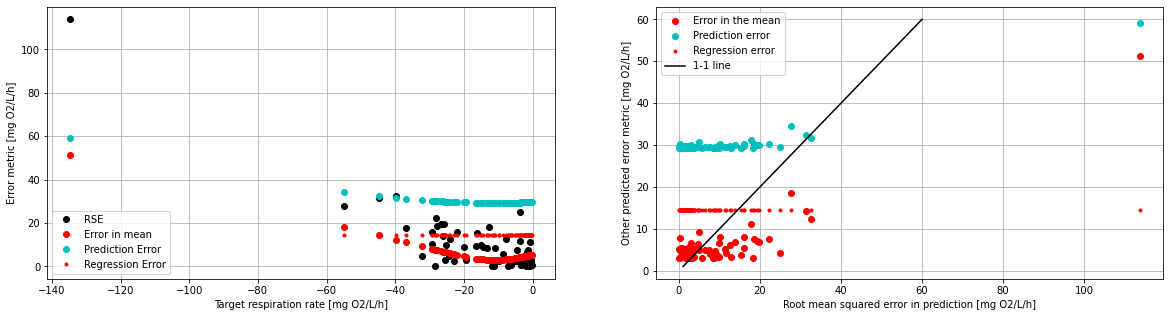

In [10]:
# Compute statistics associated with the line of
# best fit between Y_test and Y_hat_test.  The idea
# of this line is to quantify to what extent Y_test
# can be used to predict Y_hat_test -> for a given
# known target, what is returned by the ML model
# and what is the uncertainty in that value?
#
# EXPECTATION: Given the bias in the ML model
# towards the mean values of training data, 
# we would expect greater uncertainty with
# greater values of Y_test and Y_hat_test.

# UPDATE: Actually, our goal is to predict to
# what extent we can use Y_hat_test to predict
# the error since we'll be using Y_hat to estimate
# the errors.  In this case, this is exactly what
# the error in the predictons, s_p is getting at.
# Note that there was an error below in the SSE
# on Oct 29, 2021, sse_error should have been in the
# calculation, but since sse_error ~ sse, the results
# are not appreciably different.

# Equations based on McClave & Dietrich, 
# _Statistics_, 6th Ed., pp. 672, 682, 707.

n_sample_size = np.size(Y_test)
print('N = '+str(n_sample_size))

x_bar = np.mean(Y_test)
y_bar = np.mean(Y_hat_test)

ssxx = np.sum((np.squeeze(Y_test)-np.mean(Y_test))**2)
print('SSxx = '+str(ssxx))

ssyy = np.sum((np.squeeze(Y_hat_test)-np.mean(Y_hat_test))**2)
print('SSyy = '+str(ssyy))

ssxy = np.sum((np.squeeze(Y_hat_test)-np.mean(Y_hat_test))*(np.squeeze(Y_test)-np.mean(Y_test)))
print('SSxy = '+str(ssxy))

slope = ssxy/ssxx               
print('slope = '+str(slope))

intercept = y_bar - x_bar*slope
print('intercept = '+str(intercept))

# Sum squared of the errors in the testing predictions
sse = np.sum((np.squeeze(Y_test)-Y_hat_test)**2)
print('SSE = '+str(sse))

# When trying to predict error based on Y_hat,
# the sse_error = sum((error_i - mean(error))^2)
# which when expanded algebreically
sse_error = ssxx + ssyy - 2.0*ssxy
print('SSE_error = '+str(sse_error))

# Estimator for the standard error of regression between
# true targets and predicted targets.
sse = sse_error # Do this if using the test predictions to estimate the error
s = np.sqrt(sse/(n_sample_size-2))
print('s = '+str(s))

# Estimate of the sampling distribution of the predictions
# of the mean value of the targets at specific value.
# This is nice, but it's very flat -> does not change much
# based on Y_test.
ssxx = ssyy # (Include this line to for Y_hat_test as a predictor of error, otherwise Y_test is the predictor.)
s_y = 2*s*np.sqrt((1/n_sample_size) + ((np.squeeze(Y_test)-np.mean(Y_test))**2)/ssxx)
s_p = 2*s*np.sqrt(1+(1/n_sample_size) + ((np.squeeze(Y_test)-np.mean(Y_test))**2)/ssxx)

#====================================
# Empirical error estimate
#====================================
# Root squared errors
rse = np.sqrt((np.squeeze(Y_test)-Y_hat_test)**2)

# Supposedly the "best" way - fit a line between the
# the target value and the rse.
error_line = np.polynomial.polynomial.Polynomial.fit(
    np.squeeze(Y_test),
    rse,1)
error_line_xy = error_line.linspace(n=100,domain=[Y_test.min(),Y_test.max()])

# But we don't know the target - fit a line between the
# the predicted value and the rse.
error_line_y_hat = np.polynomial.polynomial.Polynomial.fit(
    np.squeeze(Y_hat_test),
    rse,1)
error_line_y_hat_xy = error_line_y_hat.linspace(n=100,domain=[Y_hat_test.min(),Y_hat_test.max()])

# Should work but I don't understand why it results in negative values...
rse_slope = np.sum((rse-np.mean(rse))*(np.squeeze(Y_test)-np.mean(Y_test)))/ssxx
rse_inter = np.mean(rse) - rse_slope*np.mean(Y_test)

#=========================
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(Y_test,rse,'ko')
#ax0.plot(Y_hat_test,rse,'k+')
#ax0.plot(Y_train,np.sqrt((np.squeeze(Y_train)-Y_hat_train)**2),'k.')
ax0.plot(Y_test,s_y,'ro')
ax0.plot(Y_test,s_p,'co')
ax0.plot(Y_test,s*np.ones(np.shape(Y_test)),'r.')
#ax0.plot(error_line_xy[0],error_line_xy[1],'g-')
#ax0.plot(error_line_y_hat_xy[0],error_line_y_hat_xy[1],'b--')
#ax0.plot(Y_train,rse_inter+rse_slope*Y_train,'go')
ax0.set_ylabel('Error metric [mg O2/L/h]')
ax0.set_xlabel('Target respiration rate [mg O2/L/h]')
ax0.legend(['RSE','Error in mean','Prediction Error','Regression Error'],loc='lower left')
ax0.grid()
#ax0.set_ylim([0,50])

ax1.plot(rse,s_y,'ro')
ax1.plot(rse,s_p,'co')
ax1.plot(rse,s*np.ones(np.shape(Y_test)),'r.')
ax1.plot([1,60],[1,60],'k-')
ax1.set_xlabel('Root mean squared error in prediction [mg O2/L/h]')
ax1.set_ylabel('Other predicted error metric [mg O2/L/h]')
ax1.legend(['Error in the mean','Prediction error','Regression error','1-1 line'])
ax1.grid()

For model nusvr-rbf ----------
---> Classical
---> r2 = 0.4246958398714041
---> R2 = 0.3457066327379136
---> Hold out
---> r2 = 0.140831896251298
---> R2 = 0.01920292607891161
For model nusvr-lin ----------
---> Classical
---> r2 = 0.2583703823547555
---> R2 = 0.20933377550978205
---> Hold out
---> r2 = 0.1325666586471615
---> R2 = 0.02345943952468732
For model nusvr-poly ----------
---> Classical
---> r2 = 0.3789616498798502
---> R2 = 0.3162741729492936
---> Hold out
---> r2 = 0.16693277904878492
---> R2 = 0.10180258281841503
For model nusvr-sig ----------
---> Classical
---> r2 = 0.028939448442668624
---> R2 = -0.00883455577184522
---> Hold out
---> r2 = 0.037472154705294525
---> R2 = -0.08134539520391093
For model knn-uni ----------
---> Classical
---> r2 = 0.7036855467976274
---> R2 = 0.7023709106794533
---> Hold out
---> r2 = 0.2542464970144191
---> R2 = 0.22959536269503045
For model knn-dist ----------
---> Classical
---> r2 = 0.7724026279192148
---> R2 = 0.7724026281413852
---> 

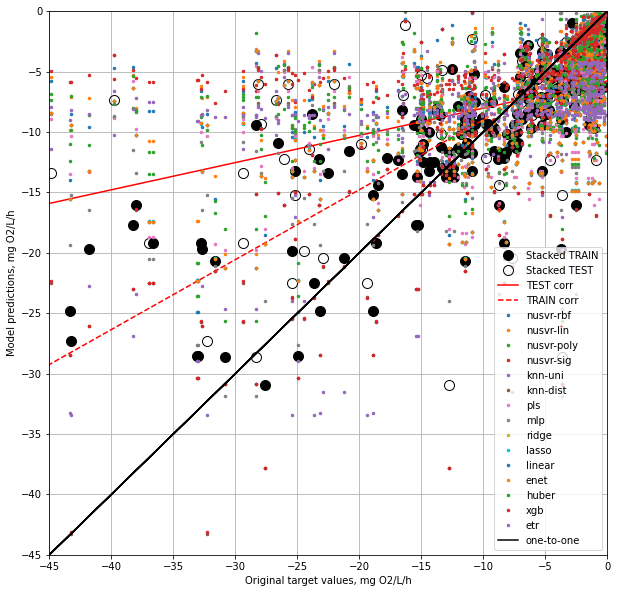

In [11]:
# Plot stacked model, predict with each submodel, plot each submodel
#plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Y_train,np.squeeze(Y_hat_train),'ko',markersize=10)
ax.plot(Y_test,np.squeeze(Y_hat_test),'ko',markersize=10,fillstyle='none')
ax.plot(test_xy[0],test_xy[1],'r-')
ax.plot(train_xy[0],train_xy[1],'r--')
ax.grid()
ax.set_xlabel('Original target values, mg O2/L/h')
ax.set_ylabel('Model predictions, mg O2/L/h')

# Predict and metric with the individual models
# (The same thing can be achieved with built in:
# superlearner['rate.mg.per.L.per.h'].transform(X)
# but done explicitly here.)
for model_name in list_models:
#for model_name in sl_models: # For a slightly simpler plot
    print('For model '+model_name+' ----------')
    model_object = superlearner['rate.mg.per.L.per.h'].named_estimators_[model_name]
    Y_hat_train_mod = model_object.predict(X_train)
    Y_hat_test_mod = model_object.predict(X_test)
    print('---> Classical')
    print('---> r2 = '+str(np.min(np.corrcoef(np.squeeze(Y_train),Y_hat_train_mod)**2)))
    print('---> R2 = '+str(model_object.score(X_train,Y_train)))
    print('---> Hold out')
    print('---> r2 = '+str(np.min(np.corrcoef(np.squeeze(Y_test),Y_hat_test_mod)**2)))
    print('---> R2 = '+str(model_object.score(X_test,Y_test)))
    # Color coded dots
    ax.plot(np.concatenate((Y_train,Y_test),axis=0),
            np.concatenate((np.squeeze(Y_hat_train_mod),np.squeeze(Y_hat_test_mod)),axis=0),
            '.',markersize=5)
    # Uniform black dots
    #ax.plot(Y,np.squeeze(Y_hat_mod),'k.',markersize=5)
    #ax.plot(Y_test,np.squeeze(Y_hat_test_mod),'k.',markersize=5)
    
# One-to-one line
ax.plot(Y_all,Y_all,'k')

# Plot stacked values one more time (for DOE figure)
#ax.plot(Y,np.squeeze(Y_hat),'ro',markersize=10)
#ax.plot(Y_test,np.squeeze(Y_hat_test),'ro',markersize=10)

# Set zoom
ax.set_xlim([-45,0])
ax.set_ylim([-45,0])

# Legend
ax.legend(['Stacked TRAIN','Stacked TEST','TEST corr','TRAIN corr']+list_models+['one-to-one'])

#ax.errorbar(Y_test,intercept+slope*Y_test,yerr=s_y)

# Biases in models due to distribution of target values
The SL seems to be biased with lower respiration rates (values closer to zero).  This may be due to the fact that the ML models are fit on a dataset that has lots of values in the range 0 to -10 and fewer respiration rates that are greater.  The histogram below quantifies this distribution and it seems that -15 mg O2/L/h is a cut point for perhaps training two models.

Text(0, 0.5, 'Frequency')

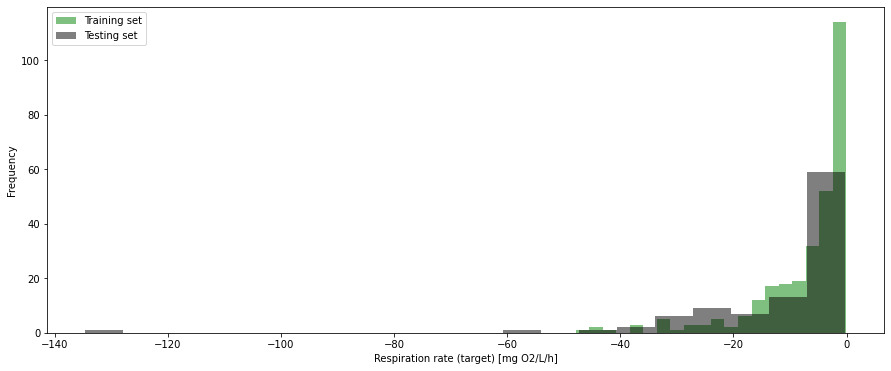

In [12]:
fig, ax = plt.subplots(figsize=(15,6))
n, bins, patches = ax.hist(Y_train, 20, density=False, facecolor='g', alpha=0.5, align='mid', histtype='stepfilled')
n, bins, patches = ax.hist(Y_test, 20, density=False, facecolor='k', alpha=0.5, align='mid', histtype='stepfilled')
ax.legend(['Training set','Testing set'])
ax.set_xlabel('Respiration rate (target) [mg O2/L/h]')
ax.set_ylabel('Frequency')

# Predictions with different inputs

Now use data from the merged GLORICH/Hydrosheds data set to compute respiration rate on a global scale.

In [13]:
predict = True
if predict :
    # For CONUS results presented to community meeting:
    #predict_file_name = 'WH_RA_GL_global_predict_25_inputs.csv'
    #predict_file_ixy = 'whondrml_global_train_xy.csv'
    #predict_out_file = 'GLORICH_global_predictions_v2.csv'
    
    # For other results:
    #predict_file_name = 'collab_predict_25_inputs.csv'
    #predict_file_ixy = 'collab_predict_ixy.csv'
    #predict_out_file = 'collab_predict_output.csv'
    
    predict_file_name = 'WH_RA_GL_global_predict_25_inputs.csv'
    predict_file_ixy = 'WH_RA_GL_global_predict_ixy.csv'
    predict_out_file = 'GLORICH_global_predictions_updated.csv'
    
    predict_df = pd.read_csv(
        predict_file_name).astype(np.float32)
    predict_df.fillna(predict_df.mean(),inplace=True)
    X = predict_df.values

    # When computing prediction, note that abs() is called to make all latitudes positive
    # (i.e. reflected across the equator).  The other variables should all be positive
    # so a global abs shouldn't be an issue.
    #Y_predict = superlearner['rate.mg.per.L.per.h'].predict(np.abs(X))
    # Remove abs operator above since latitude is no longer being used as an input
    # (and hasn't for a a very long time)
    Y_predict = superlearner['rate.mg.per.L.per.h'].predict(X)

    # Estimate the error based on the training data
    Y_hat_error = 2*s*np.sqrt((1/n_sample_size) + ((np.squeeze(Y_predict)-np.mean(Y_test))**2)/ssxx)
    Y_hat_pred_error = 2*s*np.sqrt(1+(1/n_sample_size) + ((np.squeeze(Y_predict)-np.mean(Y_test))**2)/ssxx)
    Y_hat_empir_err = rse_inter+rse_slope*Y_predict
    
    # Put the predictions with lon lat data separated beforehand.
    output_df = pd.read_csv(predict_file_ixy)
        
    output_df[target_name] = pd.Series(Y_predict)
    output_df['mean.error'] = pd.Series(Y_hat_error)
    output_df['predict.error'] = pd.Series(Y_hat_pred_error)
    #output_df['empirical.error'] = pd.Series(Y_hat_empir_err)
    output_df.to_csv(
        predict_out_file,
        index=False,
        na_rep='NaN')

# Feature permutation importance (FPI)

Which of the many possible inputs (i.e. "features") is most important?  Here, we address this question by permuting the inputs to see which have the biggest impact on the results.  We also need to experiment with grouping together correlated features.  If features are significantly correlated with each other, then they need to be permuted together, otherwise when a feature is permuted, the model can still get information from the other, correlated features, meaning that the final predicted values may not change substantially -> the importance will be "diluted" across the correlated features.

Although no model fitting is required, this can TAKE A VERY LONG TIME to run even for a small data set - bigger data sets and exploring variability among models warrents a separate parallelized workflow.

In [ ]:
# FPI functions

#=====================================================================================
def permute_importance(permutation_feature_blocks_str, model, X, y, scoring_func, n_repeats=20, ratio_score=True):
    base_preds = model.predict(X.values)
    base_score = scoring_func(y, base_preds)

    blocks, block_names = parse_permutation_feature_blocks(permutation_feature_blocks_str, X.columns)
    block_scores = list()
    for block, block_name in zip(blocks, block_names):
        block_df = X.copy()
        repeat_scores = list()
        for i_repeat in range(n_repeats):
            print('For block '+block[0]+' iteration '+str(i_repeat))
            block_df[block] = shuffle(block_df[block]).values
            repeat_preds = model.predict(block_df.values)
            repeat_scores.append(scoring_func(y, repeat_preds))

        # Get block score
        importance_score_mean = np.mean(repeat_scores) / base_score if ratio_score else np.mean(repeat_scores) - base_score
        importance_score_std = np.std(repeat_scores) / base_score if ratio_score else np.std(repeat_scores) - base_score
        block_scores.append((block_name, importance_score_mean, importance_score_std))

    # Return output sorted by the mean ratio of change (second column)
    # For coalescing FPI output from many runs, we don't want this
    # sorting - just return the scores unsorted and we'll take the mean
    # over many models and then sort later.
    #return sorted(block_scores, key=lambda r: r[1], reverse=True)
    return block_scores

#=====================================================================================
def parse_permutation_feature_blocks(permutation_feature_blocks_str, df_column_index):
    blocks = [
        [bl_item.strip() for bl_item in bl.strip().split(',')]
        for bl in permutation_feature_blocks_str.strip().split(';')
    ]  if permutation_feature_blocks_str else list()

    column_idx = {v: k for k, v in enumerate(df_column_index)}
    blocks_ = list()
    blocks_names = list()
    explicit_blocks = set()
    for bl in blocks:
        parsed_block = list()
        for bl_item in bl:
            if ':' in bl_item:
                start_col, end_col = bl_item.split(':')
                parsed_block.extend(list(df_column_index[column_idx[start_col]:column_idx[end_col] + 1]))
            else:
                parsed_block.append(bl_item)
        blocks_.append(parsed_block)
        blocks_names.append(','.join(bl))
        explicit_blocks = explicit_blocks.union(set(parsed_block))

    for singleton in set(df_column_index) - explicit_blocks:
        blocks_.append([singleton])
        blocks_names.append(singleton)
    return blocks_, blocks_names

#=============================================================================
# FPI only works if correlated features are permuted together.
# Otherwise, correlated features permuted independently
# will dilute the impact of that feature since the ML model
# will still get some information from the unpermuted feature.
#
# --- Conventions ---
# Within each group of features, the feature names are separated by commas.
# The groups of features are separated by semi-colons.
# Colons can be used for contiguous feature grouping, but this currently
# ignored because need to come up with a reliable way to generalize processing
# this case since it assumes the same feature names throughout.
#
# Inputs: Takes a list of feature names and a correlation heatmap between features
# (One could just pass a .csv file and compute the correlation internally, but keep
# separate for now to enable plotting and debugging.)
def group_correlated_features(
    feature_corr,
    corr_cutoff=0.4,
    merge_groups=False,
    onehot_list=[],
    verbose=False):
    
    # Take absolute value of the correlations.
    abs_corr = np.abs(feature_corr)
    
    # First get rid of diagonal (but allowing for 1.0 correlations 
    # elsewhere, e.g. duplicate features)
    feature_names_str = feature_corr.columns
    for name in feature_names_str:
        abs_corr.loc[name,name] = 0
    
    # Initialize tracker for highest correlation detected
    current_highest_corr = 1.0
    
    # Initialize list of groups
    # (Simple approach, ignoring one-hot features)
    feature_groups_list = []
    
    # For one-hot features, we want to ensure all one-of-k streams
    # are all permuted together.  This means that we pre-populate
    # the feature_groups_list with the user specified one-hot 
    # features.  These features are identified by their prefix.
    # If a prefix is in the list, a new group is created and
    # all features in the list that match the prefix
    # are automatically included in the group.  Later, if one
    # (or more) of the one-hot streams in each one-hot feature
    # correlates with another feature, those features can be
    # merged, but all the streams from a one-hot feature will
    # be carried as a block.
    for prefix in onehot_list:
        
        if verbose:
            print('Finding one-hot features based on given prefix: '+prefix)
        # Create a new group for elements found with this prefix.
        prefix_match = [s for s in feature_names_str if prefix in s]
        
        jj = 0
        for feature in prefix_match:
            if jj == 0:
                if verbose:
                    print('Creating one-hot group for feature: '+feature)
                # Create the group with first feature
                feature_groups_list.append(feature)
                jj = 1
            else:
                if verbose:
                    print('Appending to one-hot group: '+feature)
                feature_groups_list[-1] = feature_groups_list[-1]+','+feature
    
    # Initialize a counter to track number of times doing this
    ii = 1
    
    while current_highest_corr >= corr_cutoff :
        
        # Scalar highest correlation in DF, could be duplicated
        current_highest_corr = abs_corr.max().max()
        
        # Get locations of current_highest_corr, DF True at current_highest_corr
        bool_current_highest_corr = abs_corr==current_highest_corr
        
        # Get DF of NaN except 1's at locations of current_highest_corr
        loc_current_highest_corr = abs_corr[bool_current_highest_corr]/current_highest_corr
        
        # Count number of highest correlations in DF.  Divide by
        # two because the corr DF is symmetric.
        num_highest_corr = np.nansum(loc_current_highest_corr)/2
                
        if verbose:
            print('Found highest correlation: '+str(current_highest_corr)+' with '+str(num_highest_corr)+' instances, iteration '+str(ii))
        
        # Find the features involved in this correlation
        features_in_corr = []
        index_current_highest_corr = np.where(bool_current_highest_corr)
        for jj in index_current_highest_corr :
            for kk in jj :
                features_in_corr.append(abs_corr.index[kk])
        
        # Get a unique list of features in correlation
        features_in_corr = list(set(features_in_corr))
        features_in_corr_group_id = np.full(np.shape(features_in_corr),np.nan)
        
        # Check if any features_in_corr are already assigned in a group
        for fid,feature in enumerate(features_in_corr) :
            # Search for this feature in feature_groups_list
            for gid,group in enumerate(feature_groups_list):
                for feature_in_group in group.split(','):
                    if (feature == feature_in_group):
                        features_in_corr_group_id[fid] = gid
        
        if verbose:
            print('Found correlation:-----------------------------------------------')
            print(features_in_corr)
            print('Starting gids:---------------------------------------------------')
            print(features_in_corr_group_id)
            print('Starting feature list:-------------------------------------------')
            print(feature_groups_list)
        
        if np.nansum(np.isfinite(features_in_corr_group_id)) == 0:
            if verbose:
                print('No features already in group.')
            # None of the features in this corr are in a grouping so
            # make a new group with all features.
            for fid,feature in enumerate(features_in_corr):
                if fid == 0:
                    # Create group for first feature
                    if verbose:
                        print('Creating new group----------------------------<===')
                    feature_groups_list.append(feature)
                else:
                    # Add features to the group
                    feature_groups_list[-1] = feature_groups_list[-1]+','+feature
                    
        elif np.nansum(np.isfinite(features_in_corr_group_id)) == 1:
            if verbose:
                print('Exactly one feature already in group.')
            # Exactly one of the features is already in a group so
            # Add the other features (with group id == NaN) to that group.
            # Find the group id of the ONE feature already in a group:
            gid = int(np.nansum(features_in_corr_group_id))
            for fid,feature in enumerate(features_in_corr):
                if np.isnan(features_in_corr_group_id[fid]):
                    feature_groups_list[gid] = feature_groups_list[gid]+','+feature
        else:
            # There is some combination of at least two 
            # features in existing groups and some other
            # feaures may or may not be in groups.  Some
            # of the features could already be in the same
            # group.  For cases when there there always exactly
            # one correlation pair detected, then no new groups
            # are created with merge_groups=False because the
            # two correlated features already belong to different
            # groups.
            if np.all(features_in_corr_group_id == features_in_corr_group_id[0]):
                # Special case when all features detected are 
                # already assigned to the same group.
                if verbose:
                    print('All features already in same group. Do nothing.')
            elif merge_groups:
                if verbose:
                    print('Merge all groups/new features for this correlation.')
                # Merge any groups associated with any feature detected here.
                jj = 0
                gid_merged = []
                for fid,feature in enumerate(features_in_corr):
                    gid = features_in_corr_group_id[fid]
                    if verbose:
                        print('For feature: '+feature+' with gid: '+str(gid))
                    if (jj == 0):
                        # Always create a new group for the supergroup we're
                        # about to build.
                        if verbose:
                            print('Creating new group----------------------------<===')
                        if np.isnan(gid):
                            # The first feature does not have a group, so create
                            # the new supergroup with just it.
                            if verbose:
                                print('New group is feature: '+feature)
                            feature_groups_list.append(feature)
                        else:
                            # Convert gid to int now that we know that gid is not NaN
                            gid = int(gid)
                            
                            # The first feature has a group, so create the new supergroup
                            # as a duplicate of the first feature's group.
                            if verbose:
                                print('New group is duplicate group: '+feature_groups_list[gid])
                            feature_groups_list.append(feature_groups_list[gid])
                            
                            # Keep track of which groups have already been merged.
                            gid_merged.append(gid)
                        jj = 1
                    else:
                        # The new supergroup exists, so append group/feature names
                        # if it hasn't been appended before.
                        if np.isnan(gid):
                            # Feature with no group, append to supergroup
                            if verbose:
                                print('Feature with no group -> simple append')
                                print('Appending feature: '+feature+' to group: '+feature_groups_list[-1])
                            feature_groups_list[-1] = feature_groups_list[-1]+','+feature
                        else:
                            # Convert gid to int now that we know that gid is not NaN
                            gid = int(gid)
                            
                            if gid in gid_merged:
                                # Feature with a group but group has already been merged.
                                if verbose:
                                    print('Group already appended, skip this feature.')
                            else:
                                # Feature with a group, group has not already 
                                # been appended.  Append now.
                                if verbose:
                                    print('Group not already appended.')
                                    print('Appending group: '+feature_groups_list[gid]+' to group: '+feature_groups_list[-1])
                                feature_groups_list[-1] = feature_groups_list[-1]+','+feature_groups_list[gid]
                                gid_merged.append(gid)
                # Now that we are done creating the new supergroup, clean up
                # by deleting the existing groups that have been merged into
                # the supergroup.  Note that removal of merged groups MUST
                # proceed in sorted, high GID to low GID because the length
                # of the list is changed with pop operations, so the GIDs are
                # reset.  Also add list(set()) inside to ensure that if there
                # are duplicate groups being merged, there is only one group
                # delete operation.
                if verbose:
                    print('Delete merged groups.')
                    print(gid_merged)
                    print(list(set(gid_merged)))
                for gid in sorted(list(set(gid_merged)), reverse=True):
                    if verbose:
                        print('Deleting merged group '+feature_groups_list[gid]+'----------------------<===')
                    feature_groups_list.pop(gid)
                
            else:
                if verbose:
                    print('Leave existing groups, create new group for extra features.')
                # Leave any existing groups separate. Any features not 
                # associated with a group initiate their own group
                jj = 0
                for fid,feature in enumerate(features_in_corr):
                    if np.isnan(features_in_corr_group_id[fid]):
                        # Add this feature to new group
                        if jj == 0:
                            # First need to create the new group
                            if verbose:
                                print('Creating new group '+feature+'----------------------------<===')
                            feature_groups_list.append(feature)
                            jj = 1
                        else:
                            # Add features to the new group
                            feature_groups_list[-1] = feature_groups_list[-1]+','+feature
        
        # Move to the next highest correlation
        abs_corr[abs_corr==current_highest_corr] = 0
        ii = ii + 1
        
    # Any remaining features are permuted independently and so
    # by default do not need to be included in the group lists.
    
    # Concatenate feature_groups_list to feature_groups_str.
    jj = 0
    ff = 0
    ff_list = []
    for group in feature_groups_list:
        if jj == 0:
            feature_groups_str = group
            jj = 1
        else:
            feature_groups_str = feature_groups_str+";"+group
            
        # Count features and check for duplicates
        for feature in group.split(','):
            ff = ff + 1
            for feature_already_seen in ff_list:
                if feature == feature_already_seen:
                    print('WARNING: Duplicate feature detected: '+str(feature)+' '+str(ff))
            ff_list.append(feature)
            
    # Print summary
    print('Started with '+str(len(feature_names_str))+' features.')
    print('Finishing with '+str(ff)+' features in '+str(len(feature_groups_list))+' groups.')
    
    return feature_groups_str

In [ ]:
# Step 1: Compute traditional correlations between all inputs and plot.
# With lots of data, this is hard to interpret!
fig, ax = plt.subplots(figsize=(15,15))
corr = all_df.corr()
short_names = [name[:12] for name in corr.columns]
sns.heatmap(ax=ax, data=np.abs(corr), xticklabels=short_names, yticklabels=short_names, cmap=sns.diverging_palette(220, 10, as_cmap=True,n=3))

In [ ]:
group_correlated_features(
    corr,
    corr_cutoff=0.5,
    merge_groups=True,
    onehot_list=['General_Vegetation','River_Gradient','Sediment','Deposition','Hydrogeomorphology'],
    verbose=False)

In [ ]:
# Step 2: What is the distribution of correlations?
# Is there a particular correlation cutoff that is relevant for this data set?
# In processing corr for plotting, first grab the lower triangle of the correlation
# heat map since the heat map is symmetric.  Then, reshape it to a vector, and then take
# the absolute value since we treat negative and positive correlations as the same.
fig, ax = plt.subplots(figsize=(15,6))
n, bins, patches = ax.hist(np.reshape(np.tril(np.abs(corr)),-1), 20, density=False, facecolor='g', alpha=0.75, align='mid', histtype='stepfilled')


In [ ]:
# Step 3: Which features should be grouped together?
# Data that are inherently linked (i.e. one-hot and categorical features)?
# Expert knowledge?
# Cluster remaining data based on correlation?
corr_cutoff = 0.5
hot_spots = corr[np.abs(corr) >= corr_cutoff]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(ax=ax, data=np.abs(hot_spots), xticklabels=short_names, yticklabels=short_names, cmap=sns.diverging_palette(220, 10, as_cmap=True,n=3))

In [ ]:
# Step 4: FPI based on the grouped features

#==========================================================
# General settings here
#==========================================================

job_list = [jobid]
permute_str = group_correlated_features(
    corr,
    corr_cutoff=0.5,
    merge_groups=True,
    onehot_list=['General_Vegetation','River_Gradient','Sediment','Deposition','Hydrogeomorphology'],
    verbose=False)

#==========================================================
# Run FPI for stacked model and each individual submodel
#==========================================================
model_fpi_results = list()
sl_fpi_results = list()

i = 0
for job_id in job_list:
    
    print('Loading model for job: '+str(job_id))
    sl = pickle.load(open('/pw/jobs/'+str(job_id)+'/model_dir/SuperLearners.pkl', 'rb'))

    #----------------------------------------------------
    # FPI for stacked model
    #----------------------------------------------------
    model_object = sl[target_name]
    
    print('FPI on stacked ensemble...')
    result = permute_importance(permute_str, 
            model_object,
            all_df, 
            target_all_df,
            mean_squared_error)
    # Convert back to dataframe, consider using MultiIndex
    # functionality instead of the clunky filter below.
    result_df = pd.DataFrame(result,
                             columns=['Feature',
                                      'Avg_Ratio'+'stack'+str(job_id), 
                                      'Std_Ratio'+'stack'+str(job_id)]).set_index('Feature')
    
    sl_fpi_results.append(result_df)
    
    #----------------------------------------------------
    # FPI for each submodel individually
    #----------------------------------------------------
    for model_name in sl_models:
        model_object = sl[target_name].named_estimators_[model_name]
        
        print('FPI on ML model: '+model_name+'...')
        result = permute_importance(permute_str, 
            model_object,
            all_df, 
            target_all_df,
            mean_squared_error)
        result_df = pd.DataFrame(result,
            columns=['Feature',
            'Avg_Ratio'+model_name+str(job_id), 
            'Std_Ratio'+model_name+str(job_id)]).set_index('Feature')
        
        model_fpi_results.append(result_df)

# Merge all dataframes into a single frame with
# features as the index.
sl_fpi_results_df = pd.concat(sl_fpi_results,axis=1)
model_fpi_results_df = pd.concat(model_fpi_results,axis=1)

In [ ]:
# Stacked model results
print(sl_fpi_results_df.sort_values(by='Avg_Ratiostack'+str(jobid),axis=0,ascending=False))

In [ ]:
# All other models
for model in sl_models:
    print('--------'+model+'---------')
    print(model_fpi_results_df['Avg_Ratio'+model+str(jobid)].sort_values(axis=0,ascending=False))

In [ ]:
# To view a particular model's list,
# Choose from ['nusvr', 'mlp', 'ridge', 'xgb']
# Choose from ['Avg_Ratio', 'Std_Ratio']
pd.DataFrame(
    model_fpi_results_df.filter(
        like='nusvr',axis=1).filter(
        like='Avg_Ratio',axis=1).mean(axis=1)).sort_values(
            by=0,
            axis=0,
            ascending=False)